In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from datetime import datetime, date
import scipy
import math


In [2]:
from  helpers_db import get_engine, run_sql
engine = get_engine()
with engine.begin() as conn:
  data = run_sql(conn, """SELECT * FROM transactions ORDER BY dt""")
  df = pd.DataFrame(data)
  # df.rename(columns={"close": "Close", "open": "Open", "low": "Low", "high": "High", "volume": "Volume", "dt": "datetime"}, inplace=True)
  df.set_index("dt", inplace = True)
print(df)

                            id  broker_id   symbol  \
dt                                                   
2023-05-26 10:41:29+00:00   26  396876521     null   
2023-05-30 14:30:50+00:00  103  397981597     CSCO   
2023-06-02 15:55:12+00:00  102  399776840     PYPL   
2023-06-02 15:55:13+00:00  101  399776860     PYPL   
2023-06-12 18:39:14+00:00  100  403174115     CVNA   
...                        ...        ...      ...   
2024-04-12 16:17:28+00:00    1  531037227  EGLN.UK   
2024-04-12 16:19:44+00:00   62  531041052      LQQ   
2024-04-12 16:21:16+00:00   61  531043612     AAPL   
2024-04-12 16:21:18+00:00   60  531043644     AAPL   
2024-04-12 16:22:24+00:00   59  531045046       CI   

                                                 comment     amount   quote  \
dt                                                                            
2023-05-26 10:41:29+00:00                        Deposit  209.80000    0.00   
2023-05-30 14:30:50+00:00             OPEN BUY 2 @ 50.24  10

In [3]:
def directional_change(close: np.array, high: np.array, low: np.array, sigma: float):
    
    up_zig = True # Last extreme is a bottom. Next is a top. 
    tmp_max = high[0]
    tmp_min = low[0]
    tmp_max_i = 0
    tmp_min_i = 0

    tops = []
    bottoms = []

    for i in range(len(close)):
        if up_zig: # Last extreme is a bottom
            if high[i] > tmp_max:
                # New high, update 
                tmp_max = high[i]
                tmp_max_i = i
            elif close[i] < tmp_max - tmp_max * sigma: 
                # Price retraced by sigma %. Top confirmed, record it
                # top[0] = confirmation index
                # top[1] = index of top
                # top[2] = price of top
                top = [i, tmp_max_i, tmp_max]
                tops.append(top)

                # Setup for next bottom
                up_zig = False
                tmp_min = low[i]
                tmp_min_i = i
        else: # Last extreme is a top
            if low[i] < tmp_min:
                # New low, update 
                tmp_min = low[i]
                tmp_min_i = i
            elif close[i] > tmp_min + tmp_min * sigma: 
                # Price retraced by sigma %. Bottom confirmed, record it
                # bottom[0] = confirmation index
                # bottom[1] = index of bottom
                # bottom[2] = price of bottom
                bottom = [i, tmp_min_i, tmp_min]
                bottoms.append(bottom)

                # Setup for next top
                up_zig = True
                tmp_max = high[i]
                tmp_max_i = i

    return tops, bottoms

def get_extremes(ohlc: pd.DataFrame, sigma: float):
    tops, bottoms = directional_change(ohlc['Close'], ohlc['High'], ohlc['Low'], sigma)
    tops = pd.DataFrame(tops, columns=['conf_i', 'ext_i', 'ext_p'])
    bottoms = pd.DataFrame(bottoms, columns=['conf_i', 'ext_i', 'ext_p'])
    tops['type'] = 1
    bottoms['type'] = -1
    extremes = pd.concat([tops, bottoms])
    extremes = extremes.set_index('conf_i')
    extremes = extremes.sort_index()
    return extremes

def rw_top(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    top = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] > v or data[k - i] > v:
            top = False
            break
    
    return top

# Checks if there is a local top detected at curr index
def rw_bottom(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    bottom = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] < v or data[k - i] < v:
            bottom = False
            break
    
    return bottom

def rw_extremes(data: np.array, order:int):
    # Rolling window local tops and bottoms
    tops = []
    bottoms = []
    for i in range(len(data)):
        if rw_top(data, i, order):
            # top[0] = confirmation index
            # top[1] = index of top
            # top[2] = price of top
            top = [i, i - order, data[i - order]]
            tops.append(top)
        
        if rw_bottom(data, i, order):
            # bottom[0] = confirmation index
            # bottom[1] = index of bottom
            # bottom[2] = price of bottom
            bottom = [i, i - order, data[i - order]]
            bottoms.append(bottom)
    
    return tops, bottoms

def find_pips(data: np.array, n_pips: int, dist_measure: int):
    # dist_measure
    # 1 = Euclidean Distance
    # 2 = Perpindicular Distance
    # 3 = Vertical Distance

    pips_x = [0, len(data) - 1]  # Index
    pips_y = [data[0], data[-1]] # Price

    for curr_point in range(2, n_pips):

        md = 0.0 # Max distance
        md_i = -1 # Max distance index
        insert_index = -1

        for k in range(0, curr_point - 1):

            # Left adjacent, right adjacent indices
            left_adj = k
            right_adj = k + 1

            time_diff = pips_x[right_adj] - pips_x[left_adj]
            price_diff = pips_y[right_adj] - pips_y[left_adj]
            slope = price_diff / time_diff
            intercept = pips_y[left_adj] - pips_x[left_adj] * slope;

            for i in range(pips_x[left_adj] + 1, pips_x[right_adj]):
                
                d = 0.0 # Distance
                if dist_measure == 1: # Euclidean distance
                    d =  ( (pips_x[left_adj] - i) ** 2 + (pips_y[left_adj] - data[i]) ** 2 ) ** 0.5
                    d += ( (pips_x[right_adj] - i) ** 2 + (pips_y[right_adj] - data[i]) ** 2 ) ** 0.5
                elif dist_measure == 2: # Perpindicular distance
                    d = abs( (slope * i + intercept) - data[i] ) / (slope ** 2 + 1) ** 0.5
                else: # Vertical distance    
                    d = abs( (slope * i + intercept) - data[i] )

                if d > md:
                    md = d
                    md_i = i
                    insert_index = right_adj

        pips_x.insert(insert_index, md_i)
        pips_y.insert(insert_index, data[md_i])

    return pips_x, pips_y

def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative val if invalid 
    
    # Find the intercept of the line going through pivot point with given slope
    intercept = -slope * pivot + y[pivot]
    line_vals = slope * np.arange(len(y)) + intercept
     
    diffs = line_vals - y
    
    # Check to see if the line is valid, return -1 if it is not valid.
    if support and diffs.max() > 1e-5:
        return -1.0
    elif not support and diffs.min() < -1e-5:
        return -1.0

    # Squared sum of diffs between data and line 
    err = (diffs ** 2.0).sum()
    return err;


def optimize_slope(support: bool, pivot:int , init_slope: float, y: np.array):
    
    # Amount to change slope by. Multiplyed by opt_step
    slope_unit = (y.max() - y.min()) / len(y) 
    
    # Optmization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step # current step
    
    # Initiate at the slope of the line of best fit
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    assert(best_err >= 0.0) # Shouldn't ever fail with initial slope

    get_derivative = True
    derivative = None
    while curr_step > min_step:

        if get_derivative:
            # Numerical differentiation, increase slope by very small amount
            # to see if error increases/decreases. 
            # Gives us the direction to change slope.
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err;
            
            # If increasing by a small amount fails, 
            # try decreasing by a small amount
            if test_err < 0.0:
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0: # Derivative failed, give up
                raise Exception("Derivative failed. Check your data. ")

            get_derivative = False

        if derivative > 0.0: # Increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else: # Increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        

        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err: 
            # slope failed/didn't reduce error
            curr_step *= 0.5 # Reduce step size
        else: # test slope reduced error
            best_err = test_err 
            best_slope = test_slope
            get_derivative = True # Recompute derivative
    
    # Optimize done, return best slope and intercept
    return (best_slope, -best_slope * pivot + y[pivot])


def fit_trendlines_single(data: np.array):
    # find line of best fit (least squared) 
    # coefs[0] = slope,  coefs[1] = intercept 
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)

    # Get points of line.
    line_points = coefs[0] * x + coefs[1]

    # Find upper and lower pivot points
    upper_pivot = (data - line_points).argmax() 
    lower_pivot = (data - line_points).argmin() 
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs) 



def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)
    # coefs[0] = slope,  coefs[1] = intercept
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (high - line_points).argmax() 
    lower_pivot = (low - line_points).argmin() 
    
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)

In [4]:
df["sma_fast"] = ta.sma(df.Close, length=16)
df["sma_slow"] = ta.sma(df.Close, length=64)
df["atr"] = ta.atr(df.High, df.Low, df.Close)
df["atr_window_11"] = df.atr.rolling(window=11).mean()
df['close_smoth'] = scipy.signal.savgol_filter(df.Close, 49, 5)
df['sma_signal'] = 0.0
df['sma_signal'] = np.where(df['sma_fast'] > df['sma_slow'], 1.0, 0.0)

df['position'] = df['sma_signal'].diff()
df.tail()

,symbol,Open,High,Low,Close,Volume,sma_fast,sma_slow,atr,atr_window_11,close_smoth,sma_signal,position
datetime,,,,,,,,,,,,,
2024-04-16 16:00:00+00:00,BTCUSD,61792.0,63274.0,61714.0,62735.0,408.960007,64122.375,67933.703125,1681.918751,1661.709835,63753.912864,0.0,0.0
2024-04-16 20:00:00+00:00,BTCUSD,62717.0,64376.0,62565.0,63830.0,254.973525,64079.500,67868.140625,1691.138840,1668.327963,63641.260645,0.0,0.0
2024-04-17 00:00:00+00:00,BTCUSD,63821.0,64370.0,63622.0,63859.0,306.577593,64057.250,67808.453125,1623.771780,1667.252589,63438.945865,0.0,0.0
2024-04-17 04:00:00+00:00,BTCUSD,63848.0,64636.0,63325.0,63332.0,359.603031,64002.250,67733.562500,1601.430939,1668.267015,63119.765950,0.0,0.0
2024-04-17 08:00:00+00:00,BTCUSD,63331.0,63573.0,63312.0,63466.0,14.302788,63956.000,67658.343750,1505.685872,1653.864825,62653.355133,0.0,0.0


In [5]:
# df.Close.loc[datetime.now().date().replace(month=1, day=1):]

/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp/T/ipykernel_75503/1773196462.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_current = df.loc[beginning_of_year:]


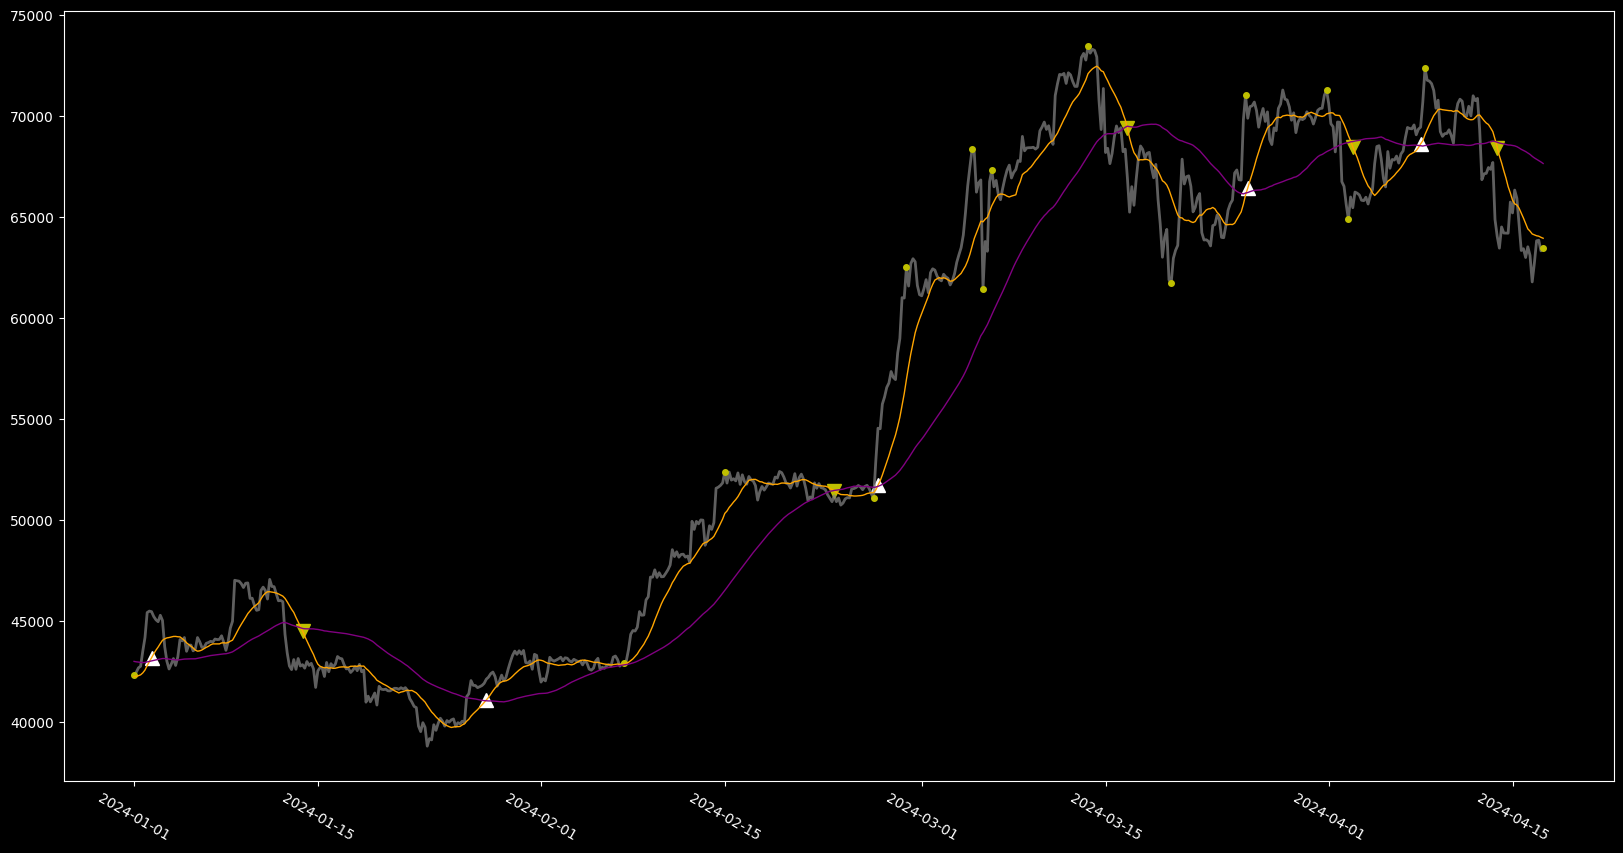

In [6]:
i = len(df)
beginning_of_year = datetime.now().date().replace(month=1, day=1)
weeks = (date.today() - beginning_of_year).days // 7
months = date.today().month
points_count = weeks

df_current = df.loc[beginning_of_year:]
x = df_current.Close.to_numpy()


pips_x, pips_y  = find_pips(x, points_count, 5)
tops, bottoms   = rw_extremes(df_current.Close.to_numpy(), 2)
tops_idx        = [top[1] for top in tops]
bottoms_idx     = [bottom[1] for bottom in bottoms]

fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.xticks(rotation=-30)
price,            = ax.plot(df_current.index,               df_current.Close,               c='grey',   zorder=5,   lw=2, alpha=0.75)
# price_smoth,      = ax.plot(df_current.index,               df_current.close_smoth,         c='b',      zorder=6,   lw=2)
peaks,            = ax.plot(df_current.index[pips_x],       df_current.Close.iloc[pips_x],  c='y',      zorder=7,   linestyle='None', markersize=4, marker="o")
# extremes_tops     = ax.plot(df_current.index[tops_idx],     df_current.Close[tops_idx],     c='g',      zorder=8,   linestyle='None', markersize=2, marker="o")
# extremes_bottoms  = ax.plot(df_current.index[bottoms_idx],  df_current.Close[bottoms_idx],  c='r',      zorder=8,   linestyle='None', markersize=2, marker="o")
extremes_bottoms  = ax.plot(df_current.index,               df_current.sma_fast,            c='orange', zorder=9,   lw=1)
extremes_bottoms  = ax.plot(df_current.index,               df_current.sma_slow,            c='purple', zorder=10,  lw=1)

# plot signals
ax.plot(df_current[df_current['position'] == 1].index, df_current['sma_fast'][df_current['position'] == 1], "^", markersize = 10, color = "w", label = 'buy')
ax.plot(df_current[df_current['position'] == -1].index, df_current['sma_fast'][df_current['position'] == -1], "v", markersize = 10, color = "y", label = 'sell')


plt.show()
plt.style.use('dark_background')
# df_current.index[pips_x]

In [22]:

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', False)
print(df.sort_index().loc[datetime.now().date().replace(month=1, day=1):].loc[df['position'] != 0])
# pd.reset_option("max_rows")
pd.reset_option('all')

                           symbol     Open     High      Low    Close       Volume    sma_fast      sma_slow          atr  atr_window_11   close_smoth  sma_signal  position
datetime                                                                                                                                                                    
2024-01-02 08:00:00+00:00  BTCUSD  45497.0  45922.0  45250.0  45467.0   501.004843  43186.1875  43035.187500   562.395390     495.254996  44260.374236         1.0       1.0
2024-01-13 20:00:00+00:00  BTCUSD  42773.0  43030.0  42702.0  42843.0   157.221297  44526.8750  44635.421875   986.516490    1098.957646  42752.467834         0.0      -1.0
2024-01-27 20:00:00+00:00  BTCUSD  41915.0  42187.0  41915.0  42124.0   154.143432  41092.0000  41052.953125   473.647438     548.814632  41982.506841         1.0       1.0
2024-02-23 08:00:00+00:00  BTCUSD  50913.0  51239.0  50829.0  51208.0   201.033015  51461.6250  51470.156250   644.939097     693.64135

/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp/T/ipykernel_75503/2164408652.py:4: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  print(df.sort_index().loc[datetime.now().date().replace(month=1, day=1):].loc[df['position'] != 0])
/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp/T/ipykernel_75503/2164408652.py:6: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option('all')
/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp/T/ipykernel_75503/2164408652.py:6: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option('all')
/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp

/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp/T/ipykernel_75503/336878517.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_current = df.loc[date.today().replace(month=1, day=1):]


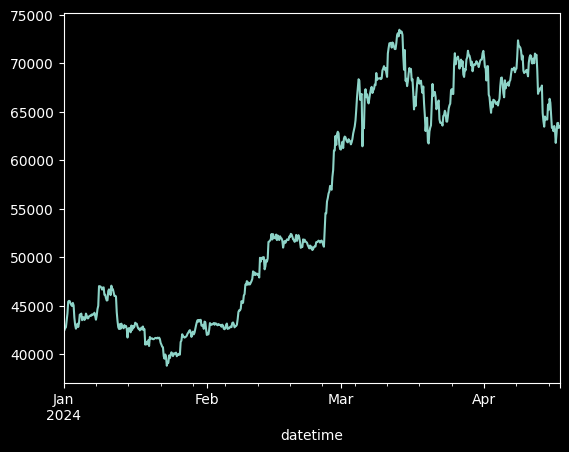

In [7]:
df_current = df.loc[date.today().replace(month=1, day=1):]
tops, bottoms = rw_extremes(df_current.Close.to_numpy(), 5)
df_current.Close.plot()
idx = df_current.index
for top in tops:
    plt.plot(idx[top[1]], top[2], marker='o', color='green')

for bottom in bottoms:
    plt.plot(idx[bottom[1]], bottom[2], marker='o', color='red')

plt.show()

In [8]:
# plt.style.use('dark_background') 


for sigma in [0.01, 0.02, 0.03, 0.04]:
    extremes = get_extremes(data, sigma)

    # Find segment heights, retracement ratios
    extremes['seg_height'] = (extremes['ext_p'] - extremes['ext_p'].shift(1)).abs()
    extremes['retrace_ratio'] = extremes['seg_height'] / extremes['seg_height'].shift(1) 
    extremes['log_retrace_ratio'] = np.log(extremes['retrace_ratio']) 



    # Find kernal of log retrace ratios
    kernal = scipy.stats.gaussian_kde(extremes['log_retrace_ratio'].dropna(), bw_method=0.01)
    retrace_range = np.arange(-3, 3, 0.001)
    retrace_pdf = kernal(retrace_range)
    retrace_pdf = pd.Series(retrace_pdf, index=np.exp(retrace_range))
    retrace_pdf.plot(color='orange', label='Retrace PDF')
    plt.axvline(0.618, label='0.618', color='blue')
    plt.axvline(1.618, label='1.618', color='green')
    plt.title("Retracement Density (Sigma=" + str(sigma) + ")")
    plt.legend()
    plt.show()

TypeError: 'CursorResult' object is not subscriptable

In [9]:
df_current = df.loc[date.today().replace(month=1, day=1):]
# df_current.reset_index(inplace=True)
data = df_current
data

/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp/T/ipykernel_75503/1358982302.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_current = df.loc[date.today().replace(month=1, day=1):]


,symbol,Open,High,Low,Close,Volume,sma_fast,sma_slow,atr,atr_window_11,close_smoth,sma_signal,position
datetime,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,BTCUSD,42258.0,42746.0,42253.0,42335.0,154.935173,42248.6875,43003.609375,481.602664,505.060721,43218.912597,0.0,0.0
2024-01-01 04:00:00+00:00,BTCUSD,42322.0,42497.0,42188.0,42465.0,75.723300,42259.7500,42982.343750,469.273902,498.621318,43389.821228,0.0,0.0
2024-01-01 08:00:00+00:00,BTCUSD,42494.0,42755.0,42452.0,42682.0,92.887872,42296.0625,42968.171875,457.397195,491.154861,43556.710946,0.0,0.0
2024-01-01 12:00:00+00:00,BTCUSD,42708.0,42840.0,42589.0,42766.0,144.080158,42339.4375,42950.875000,442.654538,483.637306,43695.479492,0.0,0.0
2024-01-01 16:00:00+00:00,BTCUSD,42793.0,43545.0,42678.0,43518.0,482.010578,42436.0000,42943.640625,472.964928,480.293083,43847.888836,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16 16:00:00+00:00,BTCUSD,61792.0,63274.0,61714.0,62735.0,408.960007,64122.3750,67933.703125,1681.918751,1661.709835,63753.912864,0.0,0.0
2024-04-16 20:00:00+00:00,BTCUSD,62717.0,64376.0,62565.0,63830.0,254.973525,64079.5000,67868.140625,1691.138840,1668.327963,63641.260645,0.0,0.0
2024-04-17 00:00:00+00:00,BTCUSD,63821.0,64370.0,63622.0,63859.0,306.577593,64057.2500,67808.453125,1623.771780,1667.252589,63438.945865,0.0,0.0


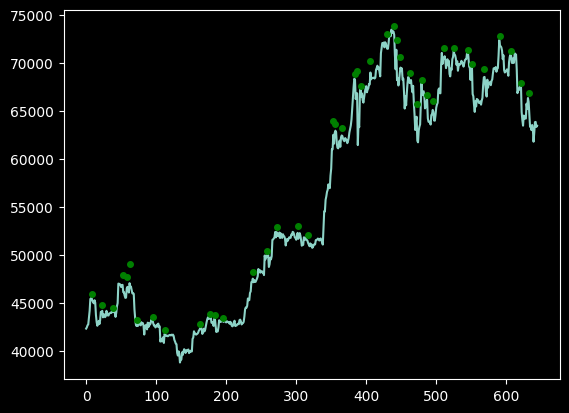

In [10]:
tops, bottoms = directional_change(data['Close'].to_numpy(), data['High'].to_numpy(), data['Low'].to_numpy(), 0.02)

pd.Series(data['Close'].to_numpy()).plot()
idx = data.index
for top in tops:
    plt.plot(top[1], top[2], marker='o', color='green', markersize=4)

plt.show()

/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp/T/ipykernel_75503/2544751040.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['support_slope'] = support_slope
/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp/T/ipykernel_75503/2544751040.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['resist_slope'] = resist_slope


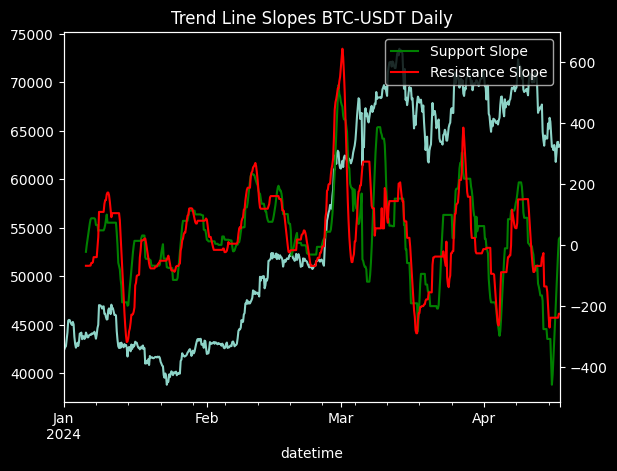

In [11]:
# data = df.loc[date.today().replace(month=1, day=1):]
# data['datetime'] = data['datetime'].astype('datetime64[s]')
# df_current['datetime']
# data = data.set_index('datetime')
# Take natural log of data to resolve price scaling issues
# data = np.log(data)
# Trendline parameter
lookback = 30


support_slope = [np.nan] * len(data)
resist_slope = [np.nan] * len(data)
for i in range(lookback - 1, len(data)):
    candles = data.iloc[i - lookback + 1: i + 1]
    support_coefs, resist_coefs =  fit_trendlines_high_low(candles['High'], 
                                                            candles['Low'], 
                                                            candles['Close'])
    support_slope[i] = support_coefs[0]
    resist_slope[i] = resist_coefs[0]

data['support_slope'] = support_slope
data['resist_slope'] = resist_slope

plt.style.use('dark_background')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
data['Close'].plot(ax=ax1)
data['support_slope'].plot(ax=ax2, label='Support Slope', color='green')
data['resist_slope'].plot(ax=ax2, label='Resistance Slope', color='red')
plt.title("Trend Line Slopes BTC-USDT Daily")
plt.legend()
plt.show()